In [59]:
# imports
import torch
from torch import nn, functional as F, optim
import sklearn.linear_model
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("paper")

%precision 2
pd.options.display.float_format = '{:,.2f}'.format

### Data - Boston House-Hrices Hataset

#### Download and prepare

In [60]:
X, y = load_boston(return_X_y=True)
data = load_boston(return_X_y=False)

scaler = StandardScaler()
y = y.reshape(506, 1)

x_norm = scaler.fit_transform(X)

In [61]:
display(X.shape)
display(y.shape)

(506, 13)

(506, 1)

In [62]:
data_df = pd.DataFrame(np.concatenate((X, y), axis=1), columns=list(data.feature_names) + ["PRICE_Y"])
data_df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE_Y
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


#### Short exploration

In [45]:
print(data.DESCR[255:1225])

  :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

 


In [46]:
data_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE_Y
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.59,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.65,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


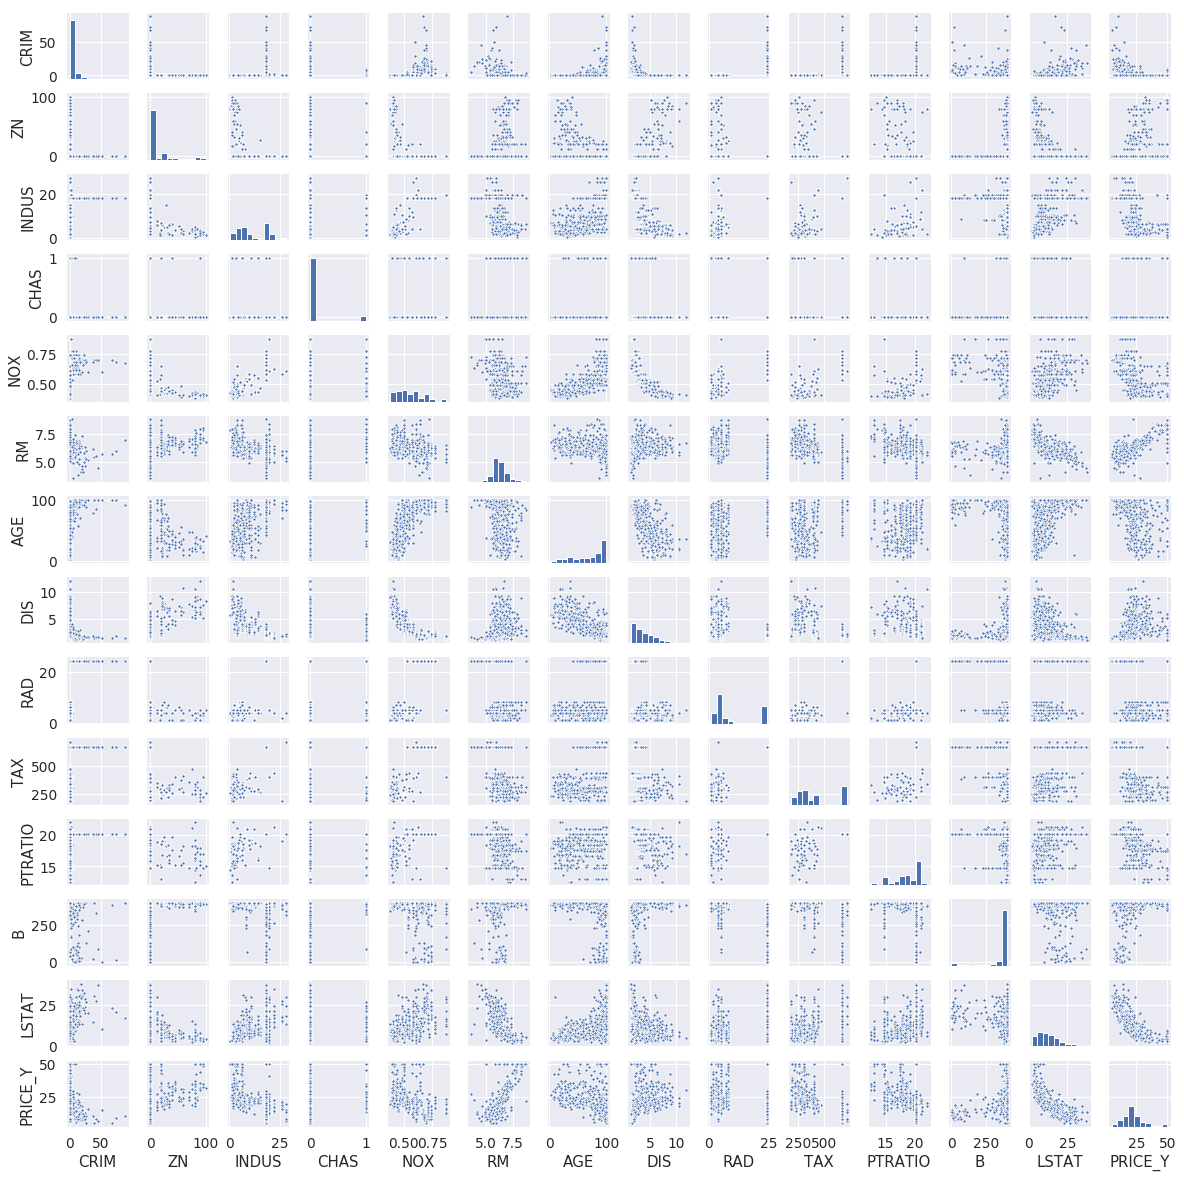

In [74]:
sns.set(font_scale=1.25)

g = sns.PairGrid(data=data_df)
g = g.map_diag(plt.hist)
g = g.map_offdiag(sns.scatterplot, s=10)
f = plt.gcf()
f.set_size_inches((16, 16))
plt.show()

### Pytorch Linear Regression

#### Regression class

In [63]:
class Regression(nn.Module):
    def __init__(self, features_num, fit_intercept=True):
        super(Regression, self).__init__()
        self.linear = nn.Linear(features_num, 1, bias=fit_intercept)

    def forward(self, x):
        return self.linear(x)

#### Train

In [75]:
def train_torch_model(X, y, model, lr, epochs, verbose=True):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()  # backward() function accumulates gradients
        
        # forward pass
        y_hat = model(X)
    
        # backward pass
        loss_var = nn.MSELoss()(y, y_hat)
        loss_var.backward()  # grads
        optimizer.step()
        losses.append(loss_var.item())
        if verbose and epoch % 50 == 0:
            print("Epoch {:4d} | Train MSE: {:10.0f}".format(epoch, loss_var.item()))
    return losses

#### Run Pytorch Regression

In [105]:
x_norm_tensor = torch.tensor(x_norm, requires_grad=True).float()
y_tensor = torch.tensor(data["target"]).float()

display(x_norm_tensor.shape)
display(y_tensor.shape)

torch.Size([506, 13])

torch.Size([506])

In [106]:
# reshape
lr_model_torch = Regression(features_num=x_norm_tensor.shape[1])
y_tensor = y_tensor.view(y_tensor.shape[0], 1)

learning_rate = 1e-4
epochs = 200

losses = train_torch_model(x_norm_tensor, y_tensor, lr_model_torch, learning_rate, epochs)


Epoch    0 | Train MSE:     295812
Epoch   50 | Train MSE:      11461
Epoch  100 | Train MSE:      11208
Epoch  150 | Train MSE:      11136


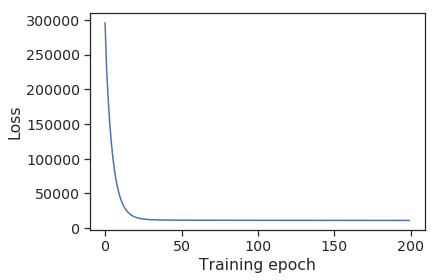

In [107]:
plt.plot(losses)
ax = plt.gca()
ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")
plt.show()

In [136]:
coef, intercept = [x.tolist() for x in lr_model_torch.parameters() ]
display(coef)
display(intercept)

[[-0.87,
  0.99,
  -0.08,
  0.71,
  -1.95,
  2.73,
  -0.02,
  -3.06,
  2.07,
  -1.44,
  -2.03,
  0.86,
  -3.72]]

[22.53]

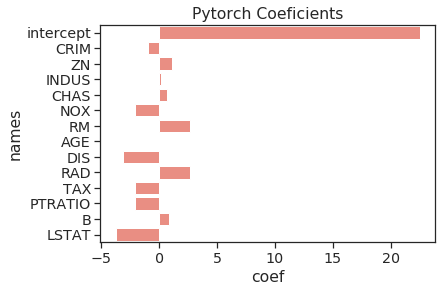

In [140]:
plot_coef(lr_model.coef_[0], 
          lr_model.intercept_[0], 
          data.feature_names, 
          color="Salmon", 
          plot_name="Pytorch Coeficients")

### Sanity Check - Sklearn Linear Regression

In [27]:
lr_model = sklearn.linear_model.LinearRegression()
lr_model.fit(x_norm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
display(lr_model.coef_)
display(lr_model.intercept_)

array([[-0.92,  1.08,  0.14,  0.68, -2.06,  2.67,  0.02, -3.1 ,  2.66,
        -2.08, -2.06,  0.86, -3.75]])

array([22.53])

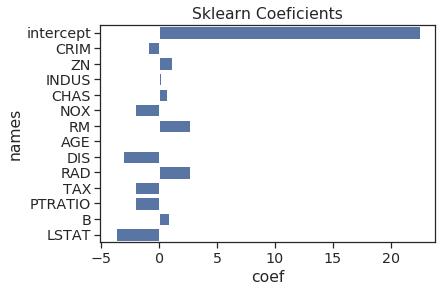

In [141]:
plot_coef(lr_model.coef_[0], 
          lr_model.intercept_[0], 
          data.feature_names, 
          plot_name="Sklearn Coeficients")

### Utils

In [103]:
def plot_coef(coefs, intercept, coef_names, color=None, plot_name=""):
    # prepare data df
    coefs_intercept = [intercept] + list(coefs)
    names = ["intercept"] + list(coef_names)
    df = pd.DataFrame({"coef": coefs_intercept, "names": names})
    # plot
    sns.set(font_scale=1.3)
    def_colors = sns.color_palette()
    sns.set_style("ticks")
    color = def_colors[0] if not color else color
    sns.barplot(x="coef", y="names", data=df, color=color)
    plt.title(plot_name)
    plt.show()    